# Deep Learning - autoencoder

### Van: Mart Veldkamp

# Inhoudsopgave

1. [Inleiding](#1)
2. [Het probleem](#2)
3. [Library's laden + data ophalen](#3)
    - [Verover de data](#4)
4. [Encoder](#5)
5. [Decoder](#6)
6. [De volledige autoencoder](#7)
7. [Reconstructie van originele afbeeldingen](#8)
    - [Conclusie reconstructie](#9)
8. [Verbeter het model](#10)
    - [Conclusie verbetering](#11)

# 1. Inleiding <a class='anchor' id='1'></a>

Deze opdracht is onderdeel van het overkoepelende vak Deep Learning, dit is één van de meerdere opgaves die ik gebruik in dit vak om te laten zien hoe deep learning gebruikt kan worden voor verschillende doeleinde. Al deze opgaves zijn daarom ook op de lossen door middel van Deep Learning.

Alle code in deze opdrachten zijn van mijzelf, gebasseerd op code uit de lessen, of waar ik zelf vast liep gebaseerd op code snippets van het internet. Mocht het toch voorkomen dat er code 1 op 1 is overgenomen, dan staat dit vermeld in de bronnen

# 2. Het probleem <a class='anchor' id='2'></a>

Het probleem dat ik in deze notebook ga behandelen is het genereren van getallen door middel van een klein stukje matrix. Dit gaan we doen door middel van de mnist dataset de Encoden en daarna de Decoden met een Decoder. Daar trekken we een conclusie uit en brengen eventueel verbeteringen aan. Om zo handgeschreven cijfers te maken.

De code in dit voorbeeld is gebaseerd op de code uit hoofdstuk 3 van *Generative Deep Learning* van David Forester, O'Reilly Media, 2019 en op hoofdstuk 8 van *Deep Learning with Python* door François Chollet, Manning, 2018.

# 3. Library's laden + data ophalen <a class='anchor' id='3'></a>

In [5]:
import numpy as np

import keras
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam

## Versie's van verschillende library's

In [7]:
print("Versie van Numpy:", np.__version__)
print("Versie van Keras:", keras.__version__)

Versie van Numpy: 1.19.5
Versie van Keras: 2.6.0


## Verover de data <a class='anchor' id='4'></a>

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
    
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

Afbeeldingen zijn 28x28 pixels in zwart/wit (1 kanaal).

We projecteren iedere afbeelding naar 2 getallen.

In [3]:
input_dim = (28, 28, 1)
z_dim = 2

# 4. Encoder <a class='anchor' id='5'></a>

We maken eerst een `encoder`. We maken hiervoor gebruik van de functionele notatie van Keras. De `encoder` is in essentie een CNN dat een afbeelding terugbrengt tot twee getallen.

In [4]:
encoder_input = Input(input_dim, name = 'encoder_input')

x = Conv2D(filters = 32,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_1')(encoder_input)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           strides = (2,2),
           padding = 'same',
           name = 'encoder_conv_2')(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           strides = (2,2),
           padding = 'same',
           name = 'encoder_conv_3')(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_4')(x)
x = LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)

encoder_output = Dense(z_dim, name = 'encoder_output')(x)

encoder = Model(encoder_input, encoder_output)

Bestudeer bovenstaande code en maak vervolgens een `summary` van het model. Komt deze samenvatting overeen met jouw verwachtingen?

In [5]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0     

# 5. Decoder <a class='anchor' id='6'></a>

Nu maken we een `decoder`. Deze vertaalt een representatie bestaande uit twee getallen naar een afbeelding.
Hiervoor gebruiken we `Conv2DTranspose` lagen.

In [6]:
decoder_input = Input((z_dim,), name = 'decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x) # van een dense vector naar de vorm van een afbeelding

x = Conv2DTranspose(filters = 64,
                kernel_size = 3,
                padding = 'same',
                name = 'decoder_conv_t_1')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 64,
                kernel_size = 3,
                strides = (2,2),
                padding = 'same',
                name = 'decoder_conv_t_2')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 32,
                kernel_size = 3,
                strides = (2,2),
                padding = 'same',
                name = 'decoder_conv_t_3')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 1,
                kernel_size = 3,
                padding = 'same',
                name = 'decoder_conv_t_4')(x)
x = LeakyReLU()(x)

decoder_output = Activation('sigmoid')(x)

decoder = Model(decoder_input, decoder_output)

Bestudeer bovenstaande code en maak vervolgens een `summary`. Merk op dat de output van de laatste laag de afmetingen heeft van een afbeelding uit de `mnist` dataset. De `decoder` is een gespiegelde versie van de `encoder`, dit is echter niet noodzakelijk, de enige eis is dat het netwerk op basis van twee getallen een afbeelding kan genereren.

In [7]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_2 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0   

# 6. De volledige autoencoder <a class='anchor' id='7'></a>

De autoencoder koppelt de `encoder` en de `decoder`. Door deze samen te trainen en als loss functie de *mean squared error* tussen de originele afbeelding (input van de encoder) en de output van de decoder te nemen, optimaliseert de autoencoder de gewichten van beide onderdelen voor het reconstrueren van afbeeldingen.

In [8]:
autoencoder = Model(encoder_input, decoder(encoder_output))

Compileer en train de `autoencoder`.

In [9]:
learning_rate = 0.0005

optimizer = Adam(lr = learning_rate)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

autoencoder.compile(optimizer = optimizer, loss = r_loss)

C:\Users\martv\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Merk op dat in onderstaande code de labels gelijk zijn aan de inputs.

In [10]:
subset = 3000

autoencoder.fit(x = x_train[:subset], y = x_train[:subset], batch_size = 32, epochs = 20, shuffle = True)

Epoch 1/20
94/94 [==============================] - 4s 33ms/step - loss: 0.1385
Epoch 2/20
94/94 [==============================] - 3s 35ms/step - loss: 0.0656
Epoch 3/20
94/94 [==============================] - 3s 36ms/step - loss: 0.0582
Epoch 4/20
94/94 [==============================] - 3s 33ms/step - loss: 0.0566
Epoch 5/20
94/94 [==============================] - 3s 33ms/step - loss: 0.0557
Epoch 6/20
94/94 [==============================] - 3s 35ms/step - loss: 0.0550
Epoch 7/20
94/94 [==============================] - 3s 33ms/step - loss: 0.0542
Epoch 8/20
94/94 [==============================] - 3s 37ms/step - loss: 0.0535
Epoch 9/20
94/94 [==============================] - 3s 36ms/step - loss: 0.0530
Epoch 10/20
94/94 [==============================] - 3s 34ms/step - loss: 0.0523
Epoch 11/20
94/94 [==============================] - 3s 35ms/step - loss: 0.0516
Epoch 12/20
94/94 [==============================] - 4s 38ms/step - loss: 0.0512
Epoch 13/20
94/94 [==================

# 7. Reconstructie van originele afbeeldingen <a class='anchor' id='8'></a>

Laten we nu eens kijken wat voor resultaten de `autoencoder` oplevert. Om te beginnen kijken we hoe goed de `decoder` in staat is om afbeeldingen te reconstrueren.

We selecteren willekeurige afbeeldingen uit de testset, coderen deze met de `encoder` en decoderen deze met de `decoder`.

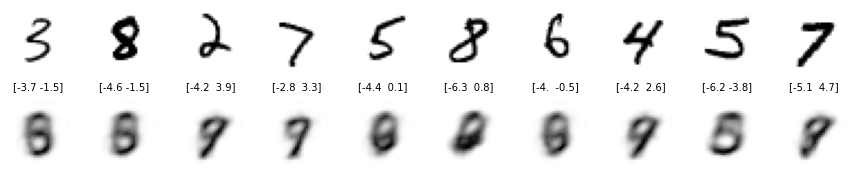

In [11]:
import matplotlib.pyplot as plt

n = 10

# selecteer willekeurige afbeeldingen uit x_test
idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[idx]

# vertaal met de encoder naar getallen
z_points = encoder.predict(test_images)

# vertaal de getallen met de decoder terug naar afbeeldingen
reconstr_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n):
    img = test_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')
    
for i in range(n):
    img = reconstr_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + n + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

## Conclusie reconstructie <a class='anchor' id='9'></a>

# 8. Verbeter het model <a class='anchor' id='10'></a>

Om een beter beeld te krijgen van het gedrag van de autoencoder, plotten we de outputs van de encoder (de 'z-waarden') voor een deel van de testset. De kleur van een punt geeft het correcte label weer.

Daarnaast selecteren we alvast een aantal willekeurige punten (dus een combinatie van twee willekeurige getallen) die we dadelijk gaan gebruiken om volledig nieuwe afbeeldingen te genereren. Deze punten worden in het rood weergegeven.

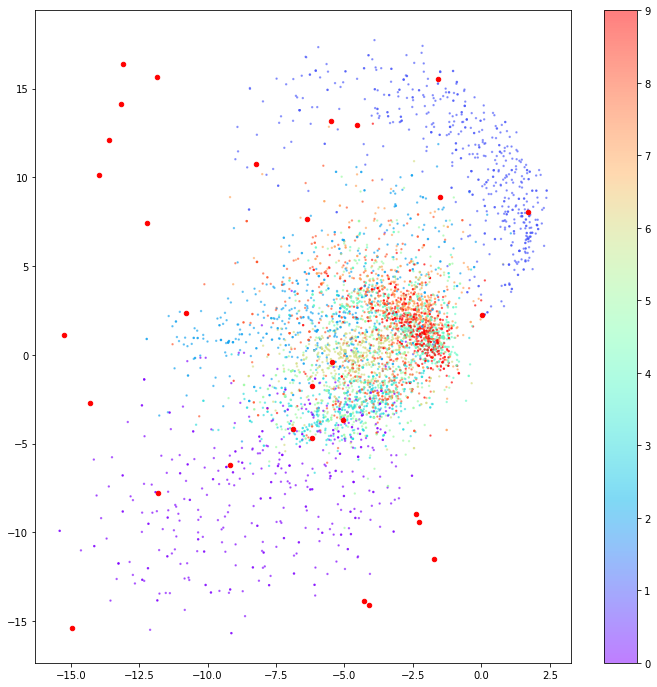

In [12]:
n = 5000
grid_size = 10
grid_depth = 3
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[example_idx]
test_labels = y_test[example_idx]

z_points = encoder.predict(test_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize = (figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap = 'rainbow' , c = test_labels, alpha = 0.5, s = 2)
plt.colorbar()

# willekeurige punten
x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

Wat valt je op aan bovenstaande plot met betrekking tot de verdeling van de labels?

### Wat valt je op aan bovenstaande plot met betrekking tot de willekeurig geselecteerde punten?

Het is allemaal erg 'dense' op 1 plek, dit komt warscheinlijk omdat meerendeel van de cijfers in het midden geschreven zijn.

We gebruiken nu de `decoder` om op basis van de willekeurig gegenereerde punten volledig nieuwe afbeeldingen te genereren en plotten deze afbeeldingen.

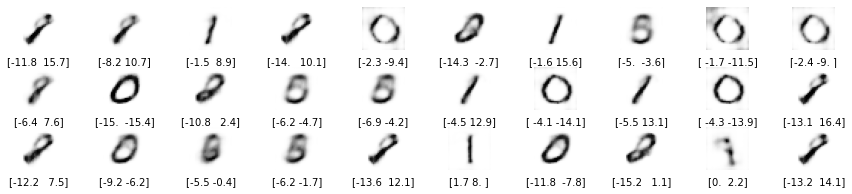

In [13]:
reconst = decoder.predict(z_grid)

figsize = 15
fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

## Conclusie verbetering <a class='anchor' id='11'></a>

De conclusie uit te resultaten is dat hoe dichter de random punten bij een 
cluster punten zitten. Hoe meer hij lijkt op een herkenbare cijfer. En omdat
de random gepakte punten niet allemaal in deze cluster vallen. Er ook niet
verwacht kan worden dat alle cijfers herkent kunnen worden. 

Daarnaast zie je als een punt tussen 2 clusters valt. Deze wat waziger 
wordt en meer een zwarte mengsel aan cijfers wordt. Omdat hij meerdere 
cijfers in één afbeelding probeert te verwerken.

Andere toepassingen kunnen zijn: Rui filteren / data compressie.